# Lab 11: Transformers

In [1]:
id = 123012
name = 'Todsavad Tangtortan'

1. Manage your available resources and continue fine-tune on the same dataset. The pretrained weights at 30th epoch (accuracy = 80%) is giving below link: (Hint: for batch_size = 8 on Puffer will used up 5GB of RAM in one GPU)

    https://drive.google.com/file/d/1P_f5OKNJuk_xpV6efLD5rFOjIyVhMW7I/view?usp=sharinghttps://drive.google.com/file/d/1P_f5OKNJuk_xpV6efLD5rFOjIyVhMW7I/view?usp=sharing

    Feel free to download the file and continue fine-tuning with different settings. Make a challenge to achieve a better performance than my result. There is no bound for the number of epochs to continue. (please don't forget to change the epoch_number=30)

In [2]:
# !pip install opencv-python
# !apt-get update
# !apt install libgl1-mesa-glx

In [3]:
# !pip install pandas
# !pip install scikit-image

In [4]:
# !pip install torch torchvision --upgrade
# !pip install vit_pytorch

In [5]:
import os
import time
import torch
import torch.nn as nn
from torchvision.models import vit_b_16 as ViT, ViT_B_16_Weights

from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

from tqdm import tqdm

import os
os.environ['http_proxy']="http://192.41.170.23:3128"
os.environ['https_proxy']="http://192.41.170.23:3128"

# Set the GPU Device
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:1


In [6]:
model = ViT(weights=ViT_B_16_Weights.DEFAULT)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"{total_params/1000000}M")

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [7]:
# Changed to out_features = 100
model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=100, bias=True))

# Move the model to Device
model.to(device)
print("Classifier Head: ", model.heads)

Classifier Head:  Sequential(
  (0): Linear(in_features=768, out_features=100, bias=True)
)


In [8]:
# Initiate the weights and biases
for m in model.heads:
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.normal_(m.bias, std=1e-6)

train_transform = transforms.Compose(
    [
    transforms.ToPILImage(mode='RGB'),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
    ]
)

val_transform = transforms.transforms.Compose(
    [
    transforms.ToPILImage(mode='RGB'),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ]
)

In [9]:
# !pip install Pillow --upgrade
# !pip install matplotlib

In [10]:
from dataset import SportDataset

csv_file = '/root/Datasets/Sports/sports.csv'
class_file = '/root/Datasets/Sports/class_dict.csv'
root_dir = '/root/Datasets/Sports'

train_ds = SportDataset(csv_file=csv_file, class_file=class_file, root_dir=root_dir, train=True, transform=train_transform)
val_ds = SportDataset(csv_file=csv_file, class_file=class_file, root_dir=root_dir, train=False, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [11]:
# !pip install tensorboardX

In [12]:
# tensorboard --logdir=/root/lab11Transformer/runs

In [13]:
from logger import Logger
from tensorboardX import SummaryWriter # have to install pip3 install tensorboardX

lr = 1e-5
epoch_number = 30 # describe the starting epoch if you are continuing training
EPOCHS = 91 # number of epochs to train
model_name = 'vit_b16'
dataset_name = 'sport_dataset'

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

logger = Logger(model_name, dataset_name)

In [14]:
print("### Start Loading Model ###")
model.load_state_dict(torch.load('Ep.30.pth',  map_location=device))
print("### Finished Loading Model ###")

<All keys matched successfully>

In [15]:
best_vloss = 100000.
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
timestamp = time.time()

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    since = time.time()
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_loss = 0.
    last_loss = 0.
    running_acc = 0.
    train_loop = tqdm(train_loader)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loop):
        # Every data instance is an input + label pair
        inputs, labels = data['image'].to(device), data['labels'].long().to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # print(labels.shape, outputs.shape)
        _, prediction = torch.max(outputs, dim=1)
        corrects = (labels == (prediction)).sum() / len(labels)
        running_acc += corrects

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        train_loop.set_postfix(loss=loss.item())

    avg_train_acc = running_acc/len(train_loader)
    avg_train_loss = running_loss/len(train_loader)

    print('Epoch {} loss: {}'.format(epoch_number+1, avg_train_loss))


    # We don't need gradients on to do reporting
    model.train(False)

    vloop = tqdm(val_loader)
    running_vloss = 0.0
    running_vacc = 0.0
    for i, data in enumerate(vloop):
        inputs, labels = data['image'].to(device), data['labels'].long().to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_vloss += loss.item()

        _, prediction = torch.max(outputs, dim=1)

        corrects = (prediction == labels).sum() / len(labels)
        running_vacc += corrects

        vloop.set_postfix(loss=loss.item())

    avg_vloss = running_vloss / len(val_loader)
    print('LOSS train {} valid {}'.format(avg_train_loss, avg_vloss))

    avg_vacc = running_vacc / len(val_loader)
    print('Accuracy train {} valid {}'.format(avg_train_acc, avg_vacc))

    # Log the running loss averaged per batch
    # for both training and validation
    logger.loss_log( train_loss=avg_train_loss,
                    val_loss=avg_vloss, nth_epoch=epoch_number+1)

    logger.acc_log( train_acc=avg_train_acc,
                    val_acc=avg_vacc, nth_epoch=epoch_number+1)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number+1)
        if epoch+1 % 10 == 0: 
            logger.save_models(model=model, nth_epoch=epoch_number+1)

    ep_duration = time.time() - since
    print("Epoch time taken: {:.0f}m {:.0f}s".format(ep_duration // 60, ep_duration % 60))
    epoch_number += 1

total_time = time.time() - timestamp
print("Total time taken: {:.0f}m {:.0f}s".format(total_time // 60, total_time % 60))

EPOCH 31:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.608]


Epoch 31 loss: 0.9092286489991581


100%|██████████| 16/16 [00:03<00:00,  4.18it/s, loss=0.908]


LOSS train 0.9092286489991581 valid 0.9122011810541153
Accuracy train 0.8447058200836182 valid 0.836718738079071
Epoch time taken: 3m 53s
EPOCH 32:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.306]


Epoch 32 loss: 0.8706562424407286


100%|██████████| 16/16 [00:03<00:00,  4.21it/s, loss=0.885]


LOSS train 0.8706562424407286 valid 0.8748568072915077
Accuracy train 0.851102888584137 valid 0.836718738079071
Epoch time taken: 3m 53s
EPOCH 33:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.725]


Epoch 33 loss: 0.8351266033509198


100%|██████████| 16/16 [00:03<00:00,  4.06it/s, loss=0.822]


LOSS train 0.8351266033509198 valid 0.8403701893985271
Accuracy train 0.8586764335632324 valid 0.840624988079071
Epoch time taken: 3m 56s
EPOCH 34:


100%|██████████| 425/425 [03:50<00:00,  1.84it/s, loss=0.912]


Epoch 34 loss: 0.800339147273232


100%|██████████| 16/16 [00:03<00:00,  4.15it/s, loss=0.774]


LOSS train 0.800339147273232 valid 0.8082048706710339
Accuracy train 0.8641176223754883 valid 0.846484363079071
Epoch time taken: 3m 55s
EPOCH 35:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.647]


Epoch 35 loss: 0.7704856484076557


100%|██████████| 16/16 [00:03<00:00,  4.12it/s, loss=0.75] 


LOSS train 0.7704856484076557 valid 0.7782379277050495
Accuracy train 0.8680881857872009 valid 0.856249988079071
Epoch time taken: 3m 53s
EPOCH 36:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=1.99] 


Epoch 36 loss: 0.7439536636717179


100%|██████████| 16/16 [00:03<00:00,  4.15it/s, loss=0.722]


LOSS train 0.7439536636717179 valid 0.7525982726365328
Accuracy train 0.8733087778091431 valid 0.862109363079071
Epoch time taken: 3m 53s
EPOCH 37:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.469]


Epoch 37 loss: 0.71425305611947


100%|██████████| 16/16 [00:03<00:00,  4.20it/s, loss=0.678]


LOSS train 0.71425305611947 valid 0.7262177933007479
Accuracy train 0.8778676390647888 valid 0.87109375
Epoch time taken: 3m 53s
EPOCH 38:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.645]


Epoch 38 loss: 0.6879269759795245


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, loss=0.666]


LOSS train 0.6879269759795245 valid 0.7000140994787216
Accuracy train 0.8824264407157898 valid 0.867968738079071
Epoch time taken: 3m 53s
EPOCH 39:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.558]


Epoch 39 loss: 0.6655448083316579


100%|██████████| 16/16 [00:03<00:00,  4.10it/s, loss=0.629]


LOSS train 0.6655448083316579 valid 0.6797144245356321
Accuracy train 0.8861764073371887 valid 0.876953125
Epoch time taken: 3m 53s
EPOCH 40:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=1]    


Epoch 40 loss: 0.6441204338915207


100%|██████████| 16/16 [00:03<00:00,  4.14it/s, loss=0.599]


LOSS train 0.6441204338915207 valid 0.6579332742840052
Accuracy train 0.8891911506652832 valid 0.876953125
Epoch time taken: 3m 54s
EPOCH 41:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.382]


Epoch 41 loss: 0.6220995396025041


100%|██████████| 16/16 [00:04<00:00,  3.92it/s, loss=0.57] 


LOSS train 0.6220995396025041 valid 0.6371945086866617
Accuracy train 0.8958088159561157 valid 0.873046875
Epoch time taken: 3m 54s
EPOCH 42:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.452]


Epoch 42 loss: 0.6007460845919217


100%|██████████| 16/16 [00:03<00:00,  4.19it/s, loss=0.559]


LOSS train 0.6007460845919217 valid 0.6208793614059687
Accuracy train 0.8997058272361755 valid 0.876953125
Epoch time taken: 3m 54s
EPOCH 43:


100%|██████████| 425/425 [03:50<00:00,  1.85it/s, loss=0.663]


Epoch 43 loss: 0.5840735389204587


100%|██████████| 16/16 [00:03<00:00,  4.21it/s, loss=0.54] 


LOSS train 0.5840735389204587 valid 0.6042516101151705
Accuracy train 0.9004411697387695 valid 0.875
Epoch time taken: 3m 54s
EPOCH 44:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=1.17] 


Epoch 44 loss: 0.5668106150627136


100%|██████████| 16/16 [00:03<00:00,  4.20it/s, loss=0.521]


LOSS train 0.5668106150627136 valid 0.5873925685882568
Accuracy train 0.9047793745994568 valid 0.880859375
Epoch time taken: 3m 53s
EPOCH 45:


100%|██████████| 425/425 [03:50<00:00,  1.84it/s, loss=0.444]


Epoch 45 loss: 0.5490735148682314


100%|██████████| 16/16 [00:03<00:00,  4.19it/s, loss=0.501]


LOSS train 0.5490735148682314 valid 0.5750409960746765
Accuracy train 0.909044086933136 valid 0.8828125
Epoch time taken: 3m 55s
EPOCH 46:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.731]


Epoch 46 loss: 0.5336992430686951


100%|██████████| 16/16 [00:03<00:00,  4.20it/s, loss=0.478]


LOSS train 0.5336992430686951 valid 0.556655440479517
Accuracy train 0.912573516368866 valid 0.888671875
Epoch time taken: 3m 54s
EPOCH 47:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.343]


Epoch 47 loss: 0.5175997879925897


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, loss=0.473]


LOSS train 0.5175997879925897 valid 0.5439559333026409
Accuracy train 0.9133087992668152 valid 0.888671875
Epoch time taken: 3m 53s
EPOCH 48:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.196]


Epoch 48 loss: 0.5021809340224547


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, loss=0.449]


LOSS train 0.5021809340224547 valid 0.53105104342103
Accuracy train 0.916985273361206 valid 0.892578125
Epoch time taken: 3m 54s
EPOCH 49:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=1.2]  


Epoch 49 loss: 0.4903567162682028


100%|██████████| 16/16 [00:03<00:00,  4.22it/s, loss=0.445]


LOSS train 0.4903567162682028 valid 0.5175435785204172
Accuracy train 0.9199264049530029 valid 0.89453125
Epoch time taken: 3m 53s
EPOCH 50:


100%|██████████| 425/425 [03:49<00:00,  1.86it/s, loss=0.543]


Epoch 50 loss: 0.47693637700641855


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, loss=0.437]


LOSS train 0.47693637700641855 valid 0.5065863076597452
Accuracy train 0.9238234758377075 valid 0.89453125
Epoch time taken: 3m 53s
EPOCH 51:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.55] 


Epoch 51 loss: 0.4633128080648534


100%|██████████| 16/16 [00:04<00:00,  3.99it/s, loss=0.42] 


LOSS train 0.4633128080648534 valid 0.49515455961227417
Accuracy train 0.9266911149024963 valid 0.8984375
Epoch time taken: 3m 53s
EPOCH 52:


100%|██████████| 425/425 [03:50<00:00,  1.84it/s, loss=0.505]


Epoch 52 loss: 0.4523327289609348


100%|██████████| 16/16 [00:03<00:00,  4.01it/s, loss=0.406]


LOSS train 0.4523327289609348 valid 0.48461744748055935
Accuracy train 0.9283823370933533 valid 0.900390625
Epoch time taken: 3m 55s
EPOCH 53:


100%|██████████| 425/425 [03:51<00:00,  1.84it/s, loss=0.395]


Epoch 53 loss: 0.4401604563699049


100%|██████████| 16/16 [00:03<00:00,  4.16it/s, loss=0.389]


LOSS train 0.4401604563699049 valid 0.4746447019279003
Accuracy train 0.9308087825775146 valid 0.904296875
Epoch time taken: 3m 55s
EPOCH 54:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.559]


Epoch 54 loss: 0.4287885188705781


100%|██████████| 16/16 [00:03<00:00,  4.18it/s, loss=0.382]


LOSS train 0.4287885188705781 valid 0.46531920321285725
Accuracy train 0.9327205419540405 valid 0.904296875
Epoch time taken: 3m 53s
EPOCH 55:


100%|██████████| 425/425 [03:49<00:00,  1.86it/s, loss=0.801]


Epoch 55 loss: 0.4186297613732955


100%|██████████| 16/16 [00:03<00:00,  4.05it/s, loss=0.373]


LOSS train 0.4186297613732955 valid 0.45740762539207935
Accuracy train 0.934926450252533 valid 0.908203125
Epoch time taken: 3m 53s
EPOCH 56:


100%|██████████| 425/425 [03:53<00:00,  1.82it/s, loss=0.111]


Epoch 56 loss: 0.40743775018874334


100%|██████████| 16/16 [00:04<00:00,  3.97it/s, loss=0.357]


LOSS train 0.40743775018874334 valid 0.4471710678189993
Accuracy train 0.9378675818443298 valid 0.91015625
Epoch time taken: 3m 57s
EPOCH 57:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=1.17] 


Epoch 57 loss: 0.40076577884309433


100%|██████████| 16/16 [00:04<00:00,  3.98it/s, loss=0.345]


LOSS train 0.40076577884309433 valid 0.439258037135005
Accuracy train 0.9392646551132202 valid 0.912109375
Epoch time taken: 3m 56s
EPOCH 58:


100%|██████████| 425/425 [03:55<00:00,  1.80it/s, loss=0.349]


Epoch 58 loss: 0.3888860802790698


100%|██████████| 16/16 [00:04<00:00,  3.93it/s, loss=0.34] 


LOSS train 0.3888860802790698 valid 0.4315406568348408
Accuracy train 0.9406617283821106 valid 0.9140625
Epoch time taken: 3m 60s
EPOCH 59:


100%|██████████| 425/425 [03:54<00:00,  1.82it/s, loss=0.103]


Epoch 59 loss: 0.37919777828104356


100%|██████████| 16/16 [00:03<00:00,  4.05it/s, loss=0.328]


LOSS train 0.37919777828104356 valid 0.4229041524231434
Accuracy train 0.943823516368866 valid 0.91796875
Epoch time taken: 3m 58s
EPOCH 60:


100%|██████████| 425/425 [03:51<00:00,  1.84it/s, loss=0.219]


Epoch 60 loss: 0.3705185336225173


100%|██████████| 16/16 [00:03<00:00,  4.15it/s, loss=0.323]


LOSS train 0.3705185336225173 valid 0.4159801471978426
Accuracy train 0.9449264407157898 valid 0.91796875
Epoch time taken: 3m 55s
EPOCH 61:


100%|██████████| 425/425 [03:50<00:00,  1.85it/s, loss=0.2]  


Epoch 61 loss: 0.3622961117239559


100%|██████████| 16/16 [00:03<00:00,  4.05it/s, loss=0.312]


LOSS train 0.3622961117239559 valid 0.4091479955241084
Accuracy train 0.9472793936729431 valid 0.919921875
Epoch time taken: 3m 54s
EPOCH 62:


100%|██████████| 425/425 [03:50<00:00,  1.84it/s, loss=0.308]


Epoch 62 loss: 0.35479932739454156


100%|██████████| 16/16 [00:03<00:00,  4.01it/s, loss=0.31] 


LOSS train 0.35479932739454156 valid 0.4017239222303033
Accuracy train 0.9465440511703491 valid 0.91796875
Epoch time taken: 3m 55s
EPOCH 63:


100%|██████████| 425/425 [03:54<00:00,  1.81it/s, loss=0.564]


Epoch 63 loss: 0.34748892465058495


100%|██████████| 16/16 [00:03<00:00,  4.06it/s, loss=0.304]


LOSS train 0.34748892465058495 valid 0.39551400672644377
Accuracy train 0.9491176009178162 valid 0.919921875
Epoch time taken: 3m 59s
EPOCH 64:


100%|██████████| 425/425 [03:53<00:00,  1.82it/s, loss=0.146]


Epoch 64 loss: 0.33851986976230847


100%|██████████| 16/16 [00:03<00:00,  4.13it/s, loss=0.296]


LOSS train 0.33851986976230847 valid 0.3897798294201493
Accuracy train 0.9505146741867065 valid 0.91796875
Epoch time taken: 3m 57s
EPOCH 65:


100%|██████████| 425/425 [03:54<00:00,  1.81it/s, loss=0.0597]


Epoch 65 loss: 0.33229362948852426


100%|██████████| 16/16 [00:03<00:00,  4.10it/s, loss=0.284]


LOSS train 0.33229362948852426 valid 0.3836500942707062
Accuracy train 0.9515441060066223 valid 0.921875
Epoch time taken: 3m 59s
EPOCH 66:


100%|██████████| 425/425 [03:56<00:00,  1.80it/s, loss=0.221]


Epoch 66 loss: 0.3240241616263109


100%|██████████| 16/16 [00:04<00:00,  3.97it/s, loss=0.28] 


LOSS train 0.3240241616263109 valid 0.3782455828040838
Accuracy train 0.9544117450714111 valid 0.9296875
Epoch time taken: 4m 0s
EPOCH 67:


100%|██████████| 425/425 [03:55<00:00,  1.81it/s, loss=0.169]


Epoch 67 loss: 0.3178333565417458


100%|██████████| 16/16 [00:03<00:00,  4.00it/s, loss=0.275]


LOSS train 0.3178333565417458 valid 0.37268697284162045
Accuracy train 0.9561764597892761 valid 0.927734375
Epoch time taken: 3m 59s
EPOCH 68:


100%|██████████| 425/425 [03:57<00:00,  1.79it/s, loss=0.201]


Epoch 68 loss: 0.31131692374453823


100%|██████████| 16/16 [00:03<00:00,  4.13it/s, loss=0.272]


LOSS train 0.31131692374453823 valid 0.3666380802169442
Accuracy train 0.957352876663208 valid 0.9296875
Epoch time taken: 4m 1s
EPOCH 69:


100%|██████████| 425/425 [03:54<00:00,  1.81it/s, loss=0.225]


Epoch 69 loss: 0.3050002656964695


100%|██████████| 16/16 [00:03<00:00,  4.15it/s, loss=0.267]


LOSS train 0.3050002656964695 valid 0.3617017325013876
Accuracy train 0.957352876663208 valid 0.93359375
Epoch time taken: 3m 59s
EPOCH 70:


100%|██████████| 425/425 [03:55<00:00,  1.80it/s, loss=0.118]


Epoch 70 loss: 0.29832651064676396


100%|██████████| 16/16 [00:03<00:00,  4.02it/s, loss=0.262]


LOSS train 0.29832651064676396 valid 0.3564029289409518
Accuracy train 0.9594852328300476 valid 0.9375
Epoch time taken: 3m 60s
EPOCH 71:


100%|██████████| 425/425 [03:55<00:00,  1.80it/s, loss=0.436]


Epoch 71 loss: 0.29207999439800486


100%|██████████| 16/16 [00:04<00:00,  3.96it/s, loss=0.254]


LOSS train 0.29207999439800486 valid 0.3538771718740463
Accuracy train 0.9605882167816162 valid 0.931640625
Epoch time taken: 3m 60s
EPOCH 72:


100%|██████████| 425/425 [03:55<00:00,  1.81it/s, loss=0.117]


Epoch 72 loss: 0.2865275741675321


100%|██████████| 16/16 [00:04<00:00,  3.86it/s, loss=0.252]


LOSS train 0.2865275741675321 valid 0.3468138091266155
Accuracy train 0.9622793793678284 valid 0.9375
Epoch time taken: 3m 59s
EPOCH 73:


100%|██████████| 425/425 [03:56<00:00,  1.80it/s, loss=0.209]


Epoch 73 loss: 0.28069135585251975


100%|██████████| 16/16 [00:03<00:00,  4.03it/s, loss=0.237]


LOSS train 0.28069135585251975 valid 0.34336353093385696
Accuracy train 0.9613969922065735 valid 0.939453125
Epoch time taken: 4m 0s
EPOCH 74:


100%|██████████| 425/425 [03:53<00:00,  1.82it/s, loss=0.0817]


Epoch 74 loss: 0.2759015065080979


100%|██████████| 16/16 [00:03<00:00,  4.03it/s, loss=0.234]


LOSS train 0.2759015065080979 valid 0.3376178443431854
Accuracy train 0.9633088111877441 valid 0.94140625
Epoch time taken: 3m 57s
EPOCH 75:


100%|██████████| 425/425 [03:51<00:00,  1.84it/s, loss=0.355]


Epoch 75 loss: 0.27083146351225235


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, loss=0.235]


LOSS train 0.27083146351225235 valid 0.33384233247488737
Accuracy train 0.9654411673545837 valid 0.94140625
Epoch time taken: 3m 55s
EPOCH 76:


100%|██████████| 425/425 [03:53<00:00,  1.82it/s, loss=0.0754]


Epoch 76 loss: 0.264225233056966


100%|██████████| 16/16 [00:03<00:00,  4.06it/s, loss=0.236]


LOSS train 0.264225233056966 valid 0.33077449910342693
Accuracy train 0.9663970470428467 valid 0.9375
Epoch time taken: 3m 58s
EPOCH 77:


100%|██████████| 425/425 [03:50<00:00,  1.85it/s, loss=0.296]


Epoch 77 loss: 0.26070594091625776


100%|██████████| 16/16 [00:04<00:00,  3.97it/s, loss=0.223]


LOSS train 0.26070594091625776 valid 0.3267780588939786
Accuracy train 0.966985285282135 valid 0.939453125
Epoch time taken: 3m 54s
EPOCH 78:


100%|██████████| 425/425 [03:50<00:00,  1.84it/s, loss=0.152]


Epoch 78 loss: 0.2549304789304733


100%|██████████| 16/16 [00:03<00:00,  4.09it/s, loss=0.22] 


LOSS train 0.2549304789304733 valid 0.32247672602534294
Accuracy train 0.9683088064193726 valid 0.94140625
Epoch time taken: 3m 55s
EPOCH 79:


100%|██████████| 425/425 [03:50<00:00,  1.85it/s, loss=0.139]


Epoch 79 loss: 0.2502949786186218


100%|██████████| 16/16 [00:03<00:00,  4.04it/s, loss=0.215]


LOSS train 0.2502949786186218 valid 0.3192863706499338
Accuracy train 0.9680882096290588 valid 0.943359375
Epoch time taken: 3m 54s
EPOCH 80:


100%|██████████| 425/425 [03:50<00:00,  1.84it/s, loss=0.635]


Epoch 80 loss: 0.2466217808863696


100%|██████████| 16/16 [00:03<00:00,  4.04it/s, loss=0.212]


LOSS train 0.2466217808863696 valid 0.3147279964759946
Accuracy train 0.9688234925270081 valid 0.943359375
Epoch time taken: 3m 55s
EPOCH 81:


100%|██████████| 425/425 [03:50<00:00,  1.85it/s, loss=0.104]


Epoch 81 loss: 0.24159161972648957


100%|██████████| 16/16 [00:04<00:00,  3.94it/s, loss=0.21] 


LOSS train 0.24159161972648957 valid 0.31229472160339355
Accuracy train 0.9700734615325928 valid 0.943359375
Epoch time taken: 3m 54s
EPOCH 82:


100%|██████████| 425/425 [03:51<00:00,  1.83it/s, loss=0.23] 


Epoch 82 loss: 0.23688337061335057


100%|██████████| 16/16 [00:03<00:00,  4.09it/s, loss=0.212]


LOSS train 0.23688337061335057 valid 0.3077662819996476
Accuracy train 0.9724999666213989 valid 0.943359375
Epoch time taken: 3m 56s
EPOCH 83:


100%|██████████| 425/425 [03:50<00:00,  1.84it/s, loss=0.216] 


Epoch 83 loss: 0.23316618177820655


100%|██████████| 16/16 [00:04<00:00,  3.94it/s, loss=0.205]


LOSS train 0.23316618177820655 valid 0.3056129990145564
Accuracy train 0.9730146527290344 valid 0.9453125
Epoch time taken: 3m 54s
EPOCH 84:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.115]


Epoch 84 loss: 0.2288807518341962


100%|██████████| 16/16 [00:04<00:00,  3.90it/s, loss=0.201]


LOSS train 0.2288807518341962 valid 0.3025565482676029
Accuracy train 0.9735293984413147 valid 0.947265625
Epoch time taken: 3m 57s
EPOCH 85:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.203] 


Epoch 85 loss: 0.22463837723521626


100%|██████████| 16/16 [00:03<00:00,  4.20it/s, loss=0.197]


LOSS train 0.22463837723521626 valid 0.2990518547594547
Accuracy train 0.9749999642372131 valid 0.9453125
Epoch time taken: 3m 53s
EPOCH 86:


100%|██████████| 425/425 [03:51<00:00,  1.84it/s, loss=0.333] 


Epoch 86 loss: 0.22119925472666235


100%|██████████| 16/16 [00:04<00:00,  3.92it/s, loss=0.196]


LOSS train 0.22119925472666235 valid 0.2963058724999428
Accuracy train 0.975147008895874 valid 0.947265625
Epoch time taken: 3m 55s
EPOCH 87:


100%|██████████| 425/425 [04:05<00:00,  1.73it/s, loss=0.156] 


Epoch 87 loss: 0.2171853703786345


100%|██████████| 16/16 [00:04<00:00,  3.83it/s, loss=0.193]


LOSS train 0.2171853703786345 valid 0.2939000427722931
Accuracy train 0.975073516368866 valid 0.947265625
Epoch time taken: 4m 10s
EPOCH 88:


100%|██████████| 425/425 [04:45<00:00,  1.49it/s, loss=0.0451]


Epoch 88 loss: 0.213690664768219


100%|██████████| 16/16 [00:04<00:00,  3.54it/s, loss=0.187]


LOSS train 0.213690664768219 valid 0.2913897028192878
Accuracy train 0.9753676056861877 valid 0.947265625
Epoch time taken: 4m 50s
EPOCH 89:


100%|██████████| 425/425 [04:05<00:00,  1.73it/s, loss=0.0946]


Epoch 89 loss: 0.20943065964123783


100%|██████████| 16/16 [00:03<00:00,  4.03it/s, loss=0.184]


LOSS train 0.20943065964123783 valid 0.2889753170311451
Accuracy train 0.9769852757453918 valid 0.943359375
Epoch time taken: 4m 10s
EPOCH 90:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.0461]


Epoch 90 loss: 0.20629795174388324


100%|██████████| 16/16 [00:03<00:00,  4.02it/s, loss=0.182]


LOSS train 0.20629795174388324 valid 0.28535670787096024
Accuracy train 0.977867603302002 valid 0.94921875
Epoch time taken: 3m 54s
EPOCH 91:


100%|██████████| 425/425 [03:51<00:00,  1.84it/s, loss=0.246] 


Epoch 91 loss: 0.2028302293489961


100%|██████████| 16/16 [00:03<00:00,  4.12it/s, loss=0.186]


LOSS train 0.2028302293489961 valid 0.28241574484854937
Accuracy train 0.9785293936729431 valid 0.951171875
Epoch time taken: 3m 55s
EPOCH 92:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.257] 


Epoch 92 loss: 0.20009364441913716


100%|██████████| 16/16 [00:04<00:00,  3.98it/s, loss=0.175]


LOSS train 0.20009364441913716 valid 0.2820408847182989
Accuracy train 0.9791176319122314 valid 0.947265625
Epoch time taken: 3m 56s
EPOCH 93:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.101] 


Epoch 93 loss: 0.19623387473471024


100%|██████████| 16/16 [00:04<00:00,  3.99it/s, loss=0.179]


LOSS train 0.19623387473471024 valid 0.27906804997473955
Accuracy train 0.9796323180198669 valid 0.951171875
Epoch time taken: 3m 56s
EPOCH 94:


100%|██████████| 425/425 [03:53<00:00,  1.82it/s, loss=0.215] 


Epoch 94 loss: 0.19334076537805445


100%|██████████| 16/16 [00:03<00:00,  4.03it/s, loss=0.175]


LOSS train 0.19334076537805445 valid 0.2769497698172927
Accuracy train 0.9801470041275024 valid 0.94921875
Epoch time taken: 3m 58s
EPOCH 95:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.383] 


Epoch 95 loss: 0.18994102676125132


100%|██████████| 16/16 [00:03<00:00,  4.01it/s, loss=0.171]


LOSS train 0.18994102676125132 valid 0.2733333110809326
Accuracy train 0.9811028838157654 valid 0.947265625
Epoch time taken: 3m 57s
EPOCH 96:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.234] 


Epoch 96 loss: 0.1867006697900155


100%|██████████| 16/16 [00:03<00:00,  4.14it/s, loss=0.174]


LOSS train 0.1867006697900155 valid 0.2718238439410925
Accuracy train 0.9808822870254517 valid 0.947265625
Epoch time taken: 3m 56s
EPOCH 97:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.184] 


Epoch 97 loss: 0.18361573641791062


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, loss=0.167]


LOSS train 0.18361573641791062 valid 0.26931706070899963
Accuracy train 0.9821323156356812 valid 0.947265625
Epoch time taken: 3m 53s
EPOCH 98:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.324] 


Epoch 98 loss: 0.18113731364993488


100%|██████████| 16/16 [00:03<00:00,  4.07it/s, loss=0.168]


LOSS train 0.18113731364993488 valid 0.2681800639256835
Accuracy train 0.982279360294342 valid 0.947265625
Epoch time taken: 3m 56s
EPOCH 99:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.124] 


Epoch 99 loss: 0.1774675845661584


100%|██████████| 16/16 [00:03<00:00,  4.03it/s, loss=0.162]


LOSS train 0.1774675845661584 valid 0.2663507033139467
Accuracy train 0.9824999570846558 valid 0.9453125
Epoch time taken: 3m 56s
EPOCH 100:


100%|██████████| 425/425 [03:53<00:00,  1.82it/s, loss=0.129] 


Epoch 100 loss: 0.17482008523800793


100%|██████████| 16/16 [00:04<00:00,  3.96it/s, loss=0.165]


LOSS train 0.17482008523800793 valid 0.2639252860099077
Accuracy train 0.9838234782218933 valid 0.947265625
Epoch time taken: 3m 58s
EPOCH 101:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.0813]


Epoch 101 loss: 0.172611723103944


100%|██████████| 16/16 [00:03<00:00,  4.09it/s, loss=0.16] 


LOSS train 0.172611723103944 valid 0.2626511277630925
Accuracy train 0.9836764335632324 valid 0.947265625
Epoch time taken: 3m 56s
EPOCH 102:


100%|██████████| 425/425 [03:52<00:00,  1.83it/s, loss=0.425] 


Epoch 102 loss: 0.17030577282695208


100%|██████████| 16/16 [00:03<00:00,  4.04it/s, loss=0.158]


LOSS train 0.17030577282695208 valid 0.25969488359987736
Accuracy train 0.984044075012207 valid 0.9453125
Epoch time taken: 3m 56s
EPOCH 103:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.0281]


Epoch 103 loss: 0.16725907338892712


100%|██████████| 16/16 [00:03<00:00,  4.18it/s, loss=0.155]


LOSS train 0.16725907338892712 valid 0.25676382426172495
Accuracy train 0.9843382239341736 valid 0.94921875
Epoch time taken: 3m 54s
EPOCH 104:


100%|██████████| 425/425 [03:55<00:00,  1.81it/s, loss=0.24]  


Epoch 104 loss: 0.16534918846452937


100%|██████████| 16/16 [00:03<00:00,  4.18it/s, loss=0.154]


LOSS train 0.16534918846452937 valid 0.25642019137740135
Accuracy train 0.9849264025688171 valid 0.9453125
Epoch time taken: 3m 59s
EPOCH 105:


100%|██████████| 425/425 [03:53<00:00,  1.82it/s, loss=0.247] 


Epoch 105 loss: 0.16265263117411558


100%|██████████| 16/16 [00:03<00:00,  4.05it/s, loss=0.158]


LOSS train 0.16265263117411558 valid 0.2544843815267086
Accuracy train 0.9855881929397583 valid 0.94921875
Epoch time taken: 3m 58s
EPOCH 106:


100%|██████████| 425/425 [03:52<00:00,  1.82it/s, loss=0.2]   


Epoch 106 loss: 0.1600733779107823


100%|██████████| 16/16 [00:04<00:00,  3.89it/s, loss=0.152]


LOSS train 0.1600733779107823 valid 0.25215839873999357
Accuracy train 0.9858823418617249 valid 0.94921875
Epoch time taken: 3m 57s
EPOCH 107:


100%|██████████| 425/425 [03:51<00:00,  1.83it/s, loss=0.263] 


Epoch 107 loss: 0.157791401927962


100%|██████████| 16/16 [00:03<00:00,  4.08it/s, loss=0.152]


LOSS train 0.157791401927962 valid 0.2504274323582649
Accuracy train 0.9863970279693604 valid 0.94921875
Epoch time taken: 3m 56s
EPOCH 108:


100%|██████████| 425/425 [03:49<00:00,  1.85it/s, loss=0.125] 


Epoch 108 loss: 0.1547462284389664


100%|██████████| 16/16 [00:03<00:00,  4.24it/s, loss=0.149]


LOSS train 0.1547462284389664 valid 0.24864165764302015
Accuracy train 0.986764669418335 valid 0.94921875
Epoch time taken: 3m 53s
EPOCH 109:


100%|██████████| 425/425 [03:47<00:00,  1.87it/s, loss=0.213] 


Epoch 109 loss: 0.15332963254521875


100%|██████████| 16/16 [00:03<00:00,  4.21it/s, loss=0.144]


LOSS train 0.15332963254521875 valid 0.24741909559816122
Accuracy train 0.9868382215499878 valid 0.94921875
Epoch time taken: 3m 51s
EPOCH 110:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.205] 


Epoch 110 loss: 0.15123620068325716


100%|██████████| 16/16 [00:03<00:00,  4.19it/s, loss=0.143]


LOSS train 0.15123620068325716 valid 0.24524625204503536
Accuracy train 0.9874999523162842 valid 0.951171875
Epoch time taken: 3m 52s
EPOCH 111:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.0863]


Epoch 111 loss: 0.14848096951842307


100%|██████████| 16/16 [00:03<00:00,  4.03it/s, loss=0.143]


LOSS train 0.14848096951842307 valid 0.24405852239578962
Accuracy train 0.9874264597892761 valid 0.94921875
Epoch time taken: 3m 52s
EPOCH 112:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.293] 


Epoch 112 loss: 0.146409753946697


100%|██████████| 16/16 [00:03<00:00,  4.19it/s, loss=0.14] 


LOSS train 0.146409753946697 valid 0.24336411617696285
Accuracy train 0.9876469969749451 valid 0.947265625
Epoch time taken: 3m 52s
EPOCH 113:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.238] 


Epoch 113 loss: 0.1445304005110965


100%|██████████| 16/16 [00:03<00:00,  4.26it/s, loss=0.138]


LOSS train 0.1445304005110965 valid 0.24088024348020554
Accuracy train 0.9880146384239197 valid 0.94921875
Epoch time taken: 3m 52s
EPOCH 114:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.0784]


Epoch 114 loss: 0.14190886706113814


100%|██████████| 16/16 [00:03<00:00,  4.19it/s, loss=0.139]


LOSS train 0.14190886706113814 valid 0.2397499131038785
Accuracy train 0.9888970255851746 valid 0.953125
Epoch time taken: 3m 52s
EPOCH 115:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.168] 


Epoch 115 loss: 0.14022423986126395


100%|██████████| 16/16 [00:03<00:00,  4.20it/s, loss=0.138]


LOSS train 0.14022423986126395 valid 0.23717800620943308
Accuracy train 0.9885293841362 valid 0.953125
Epoch time taken: 3m 52s
EPOCH 116:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.0711]


Epoch 116 loss: 0.13847211527473785


100%|██████████| 16/16 [00:03<00:00,  4.28it/s, loss=0.136]


LOSS train 0.13847211527473785 valid 0.23623186722397804
Accuracy train 0.988602876663208 valid 0.953125
Epoch time taken: 3m 52s
EPOCH 117:


100%|██████████| 425/425 [03:46<00:00,  1.87it/s, loss=0.119] 


Epoch 117 loss: 0.1367047748232589


100%|██████████| 16/16 [00:03<00:00,  4.23it/s, loss=0.136]


LOSS train 0.1367047748232589 valid 0.23541664611548185
Accuracy train 0.9890440702438354 valid 0.953125
Epoch time taken: 3m 51s
EPOCH 118:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.137] 


Epoch 118 loss: 0.13455437739982323


100%|██████████| 16/16 [00:03<00:00,  4.14it/s, loss=0.137]


LOSS train 0.13455437739982323 valid 0.2347709136083722
Accuracy train 0.9894852638244629 valid 0.953125
Epoch time taken: 3m 53s
EPOCH 119:


100%|██████████| 425/425 [03:48<00:00,  1.86it/s, loss=0.112] 


Epoch 119 loss: 0.13283952348372516


100%|██████████| 16/16 [00:03<00:00,  4.21it/s, loss=0.134]


LOSS train 0.13283952348372516 valid 0.23205858562141657
Accuracy train 0.9898529052734375 valid 0.953125
Epoch time taken: 3m 52s
EPOCH 120:


100%|██████████| 425/425 [03:47<00:00,  1.87it/s, loss=0.172] 


Epoch 120 loss: 0.1315960278055247


100%|██████████| 16/16 [00:03<00:00,  4.24it/s, loss=0.133]


LOSS train 0.1315960278055247 valid 0.23147412855178118
Accuracy train 0.9899999499320984 valid 0.95703125
Epoch time taken: 3m 52s
EPOCH 121:


100%|██████████| 425/425 [03:47<00:00,  1.87it/s, loss=0.0805]


Epoch 121 loss: 0.12873743884703692


100%|██████████| 16/16 [00:03<00:00,  4.24it/s, loss=0.132]

LOSS train 0.12873743884703692 valid 0.23023033700883389
Accuracy train 0.9908823370933533 valid 0.955078125
Epoch time taken: 3m 51s
Total time taken: 357m 54s


In [17]:
# torch.save(model.state_dict(), './saved/vit_b16/Ep.121.pth')

In [ ]:
# logger.save_models(model=model, nth_epoch=120+1)

2. With your final fine-tuned weights, try to inference and get the result on images from "test" and "images to predict" directories in sport_dataset. Visualize some random inferenced images with their predictions.

### Start Loading Model ###
class dict:  {0: 'air hockey', 1: 'ampute football', 2: 'archery', 3: 'arm wrestling', 4: 'axe throwing', 5: 'balance beam', 6: 'barell racing', 7: 'baseball', 8: 'basketball', 9: 'baton twirling', 10: 'bike polo', 11: 'billiards', 12: 'bmx', 13: 'bobsled', 14: 'bowling', 15: 'boxing', 16: 'bull riding', 17: 'bungee jumping', 18: 'canoe slamon', 19: 'cheerleading', 20: 'chuckwagon racing', 21: 'cricket', 22: 'croquet', 23: 'curling', 24: 'disc golf', 25: 'fencing', 26: 'field hockey', 27: 'figure skating men', 28: 'figure skating pairs', 29: 'figure skating women', 30: 'fly fishing', 31: 'football', 32: 'formula 1 racing', 33: 'frisbee', 34: 'gaga', 35: 'giant slalom', 36: 'golf', 37: 'hammer throw', 38: 'hang gliding', 39: 'harness racing', 40: 'high jump', 41: 'hockey', 42: 'horse jumping', 43: 'horse racing', 44: 'horseshoe pitching', 45: 'hurdles', 46: 'hydroplane racing', 47: 'ice climbing', 48: 'ice yachting', 49: 'jai alai', 50: 'javelin', 51: 'jousti

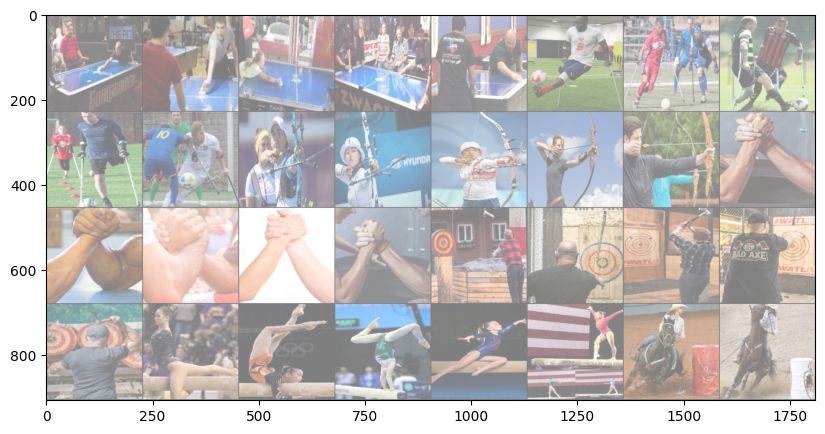

In [19]:
import matplotlib.pyplot as plt
from utils import *
import torchvision

print("### Start Loading Model ###")
model.load_state_dict(torch.load('./saved/vit_b16/Ep.121.pth',  map_location=device))
model = model.to(device)

model.eval()

class_df = pd.read_csv(class_file, usecols=['class_index', 'class'])
class_dict = { row[0]:row[1] for i, row in class_df.iterrows()}
print("class dict: ", class_dict)

dataiter = iter(val_loader)
data = next(dataiter)

plt.rcParams['figure.figsize'] = [15, 5]
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(data['image'])
matplotlib_imshow(img_grid, one_channel=False)
print(','.join(class_dict[data['labels'][j].item()] for j in range(8)))

inputs, labels = data['image'].to(device), data['labels'].long().to(device)
outputs = model(inputs)
print(f'Predict Result : {outputs}')
print(f'Actual  Result : {labels}')

3. Describe your experience on fine-turning and show the graphs from tensorboardX.

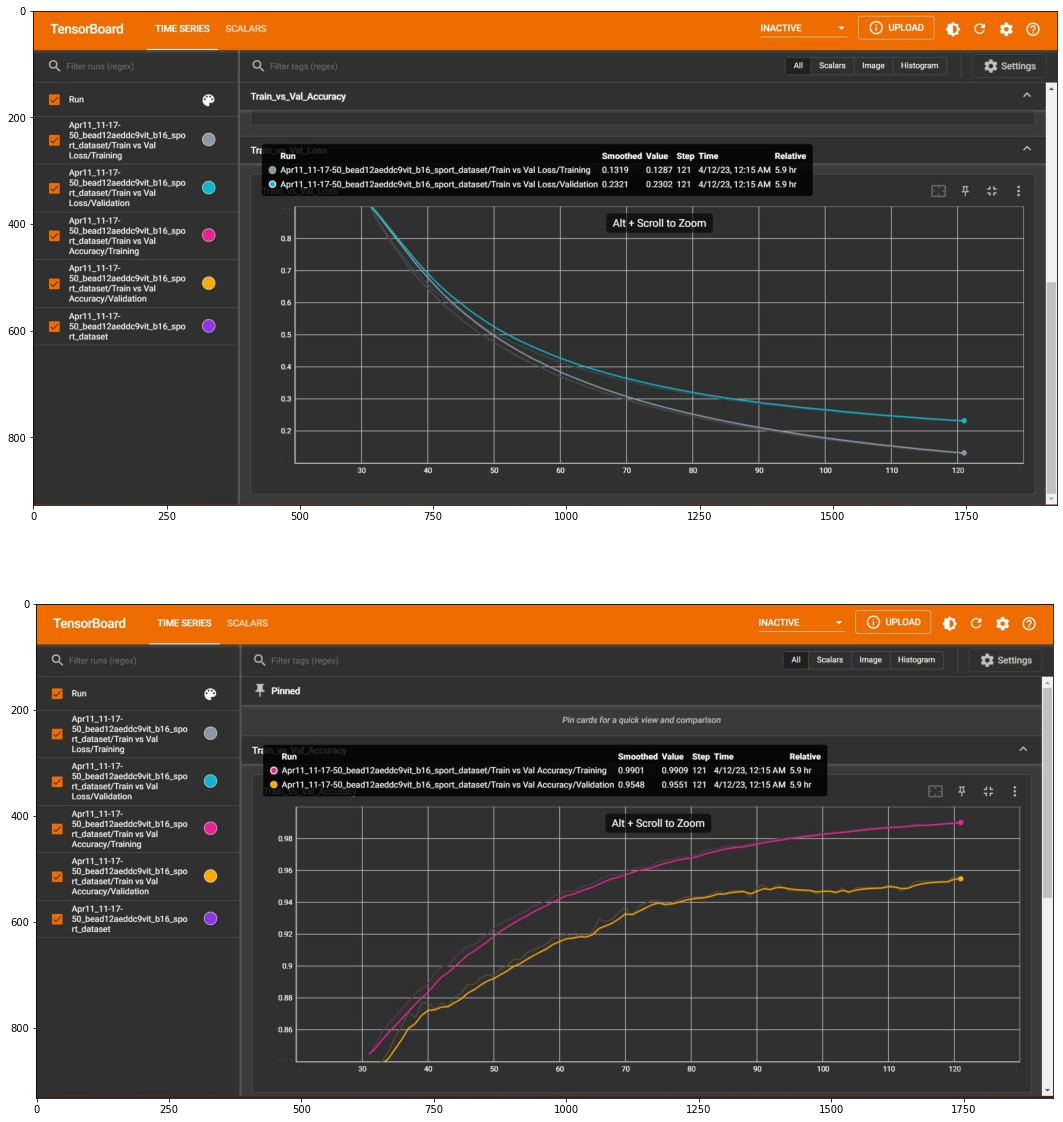

In [21]:
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(30,20))
img1 = mpimg.imread('./figure/01loss.jpg')
img2 = mpimg.imread('./figure/02acc.jpg')

plt.title('Train vs Validation')
plt.subplot(2,1,1)
plt.imshow(img1)
plt.subplot(2,1,2)
plt.imshow(img2)